# GLMM

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gpboost as gpb
# https://gpboost.readthedocs.io/en/latest/pythonapi/gpboost.GPModel.html

from patsy import dmatrix

In [16]:
filepath = '../../../data/processed/df_filtered_5years.xlsx'
df = pd.read_excel(filepath)
df['log_income'] = np.log(df['income'])
df = df.dropna()
df.head()

,island,year,island_id,region_code,region_name,prefecture_code,prefecture_code.1,population,dummy_island_has_bridge,dummy_island_is_connected_mainland,year_bridge_opened,dummy_after_bridge_opened,year_connect_mainland,dummy_after_connect_mainland,income,log_income
2,島後,2005,0,32528,隠岐の島町,32,島根県,17259.0,0,0,0,0,0,0,19083931.0,16.764357
3,島後,2010,0,32528,隠岐の島町,32,島根県,15930.0,0,0,0,0,0,0,16082881.0,16.593266
4,島後,2015,0,32528,隠岐の島町,32,島根県,14901.0,0,0,0,0,0,0,16135317.0,16.596521
5,島後,2020,0,32528,隠岐の島町,32,島根県,13882.0,0,0,0,0,0,0,17473739.0,16.676210
6,中ノ島,1985,1,32525,海士町,32,島根県,3339.0,0,0,0,0,0,0,2645758.0,14.788468


## モデルの適合

In [60]:
group = df['island_id']
y = df['population']
X = dmatrix('dummy_after_bridge_opened + log_income + C(year)', data=df, return_type='dataframe')

model = gpb.GPModel(group_data=group, likelihood="poisson")
model.fit(y=y, X=X, params={'std_dev': True})

pred = model.predict(X_pred=X, group_data_pred=group)['mu']
residuals = y - pred

print(model.summary())

Model summary:
  Log-lik      AIC     BIC
-13201.47 26424.93 26473.5
Nb. observations: 611
Nb. groups: 154 (island_id)
-----------------------------------------------------
Covariance parameters (random effects):
           Param.
island_id  5.8366
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                           Param.  Std. dev.  z value  P(>|z|)
Intercept                  7.0440        NaN      NaN      NaN
C(year)[T.1990]           -0.0642        NaN      NaN      NaN
C(year)[T.1995]           -0.1077        NaN      NaN      NaN
C(year)[T.2000]           -0.1835        NaN      NaN      NaN
C(year)[T.2005]           -0.1664        NaN      NaN      NaN
C(year)[T.2010]           -0.2726        NaN      NaN      NaN
C(year)[T.2015]           -0.2855        NaN      NaN      NaN
C(year)[T.2020]           -0.3934        NaN      NaN      NaN
dummy_after_bridge_opened -0.0298     0.0061  -4.9132      0.0
log_income         

## 残差分析

In [63]:
# 変数と残差の相関
corr_log_income = np.corrcoef(df['log_income'], residuals)[0, 1]
corr_bridge = np.corrcoef(df['dummy_after_bridge_opened'], residuals)[0, 1]
coor_population = np.corrcoef(df['population'], residuals)[0, 1]

print(f'coor between log_income and residuals: {corr_log_income:.3f}')
print(f'coor between bridge and residuals: {corr_bridge:.3f}')
print(f'coor between population and residuals: {coor_population:.3f}')

coor between log_income and residuals: -0.000
coor between bridge and residuals: -0.000
coor between population and residuals: 0.114


### 残差プロット

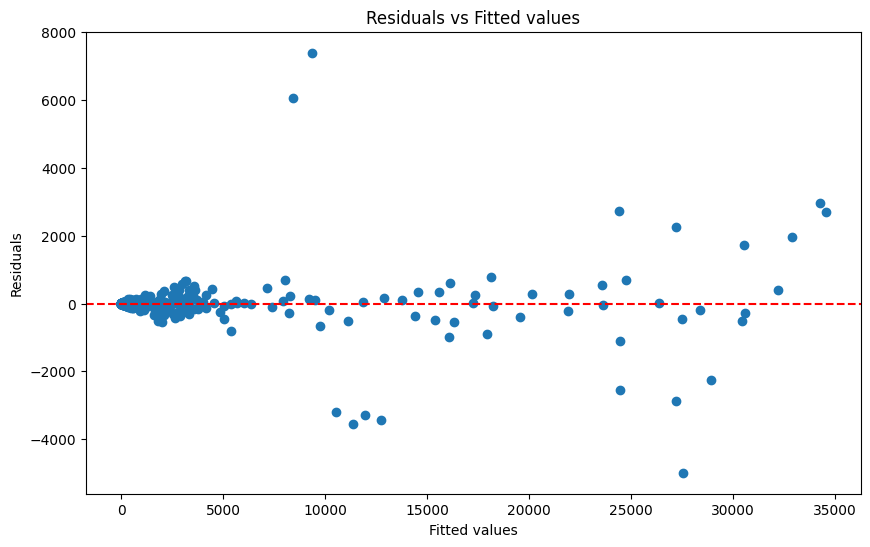

In [64]:
plt.figure(figsize=(10, 6))
plt.scatter(pred, residuals)
plt.axhline(0, color='red', ls='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.show()

### 残差ヒストグラム

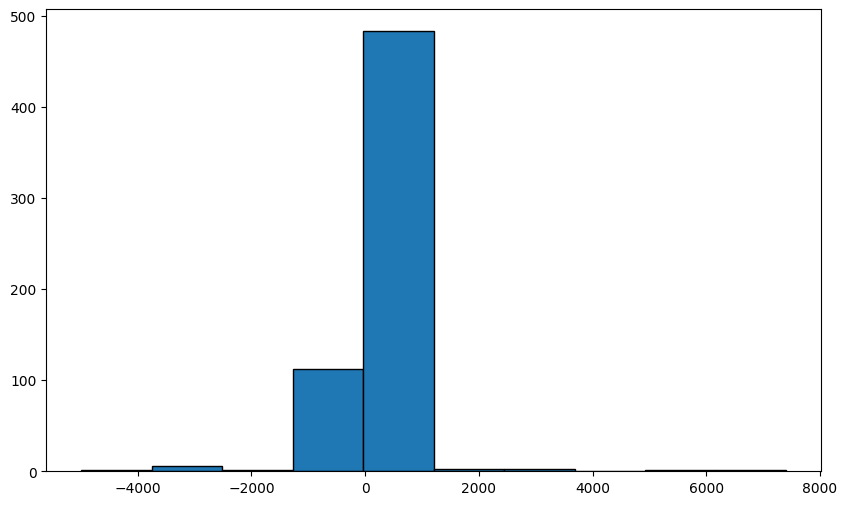

In [65]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, edgecolor='black')
plt.show()